### Accuracy Assessment
Created by Amos Bennett.<br>
Last Updated 28 Sep 20. <br>

__Updates:__ 

Calculates the accuracy matrix (crosstab matrix) of the dNBR layer. Histogram shows class separability. By selecting breaks between classes with minimal overlap, the best accuracy result can be assessed for this particular classification. Actual and classified severities are then mapped against each other (per row) and a cross tabulation calculation is conducted.

In [79]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [80]:
gdf = gpd.read_file('./training_accuracy_data.shp')
gdf = gdf.rename(columns={'Tumbarumba': 'dNBR', 'SEVERITY': 'actual_severity'})
gdf.head()

,dNBR,actual_severity,geometry
0,-0.04120,Unburnt,POINT (620890.643 5981712.721)
1,0.58526,Moderate,POINT (584229.417 5980124.584)
2,0.20552,Low,POINT (585809.421 5980766.175)
3,0.31326,Moderate,POINT (623375.568 6070297.326)
4,0.00954,Unburnt,POINT (619427.841 6050698.299)


__From dNBR raster histogram:__<br>
mix value = -0.78936<br>
max value = 1.2721

Separate each class into separate geodataframes based on the actual (measured) classes:

In [82]:
actual_unburnt = gdf.loc[(gdf['actual_severity'] == 'Unburnt')]
actual_low = gdf.loc[(gdf['actual_severity'] == 'Low')]
actual_moderate = gdf.loc[(gdf['actual_severity'] == 'Moderate')]
actual_high = gdf.loc[(gdf['actual_severity'] == 'High')]
actual_extreme = gdf.loc[(gdf['actual_severity'] == 'Extreme')]

Plot the classes (less unburnt) on a histogram to find threshold values for separation:

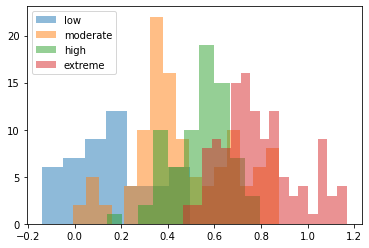

In [83]:
#plt.hist(actual_unburnt['dNBR'], bins=30, alpha = 0.5, label='unburnt')
plt.hist(actual_low['dNBR'], bins=7, alpha = 0.5, label='low')
plt.hist(actual_moderate['dNBR'], bins=16, alpha = 0.5, label='moderate')
plt.hist(actual_high['dNBR'], bins=10, alpha = 0.5, label='high')
plt.hist(actual_extreme['dNBR'], bins=17, alpha = 0.5, label='extreme')

plt.legend(loc='upper left')
plt.show()

Extremely poor separability between classes. This could be due to the accuracy data that was sourced by visually intepreting 3m resolution Planet Dove data using false colour cues. It was easy to identify 'extreme' classes that were completed charred and also unburnt healthy areas but distinguishing between low, moderate and high was very difficult.

Apply threshold values and map the categorical matches to the original geodataframe:

In [84]:
classified_unburnt = gdf.loc[(gdf['dNBR'] < 0.10)]
classified_low = gdf.loc[(gdf['dNBR'] >= 0.10) & (gdf['dNBR'] < 0.30)]
classified_moderate = gdf.loc[(gdf['dNBR'] >= 0.30) & (gdf['dNBR'] < 0.50)]
classified_high = gdf.loc[(gdf['dNBR'] >= 0.50) & (gdf['dNBR'] < 0.65)]
classified_extreme = gdf.loc[(gdf['dNBR'] >= 0.65)]

In [85]:
classified_unburnt[['classified_severity']] = 'Unburnt'
classified_low[['classified_severity']] = 'Low'
classified_moderate[['classified_severity']] = 'Moderate'
classified_high[['classified_severity']] = 'High'
classified_extreme[['classified_severity']] = 'Extreme'

/home/yobi/miniconda3/envs/geowhat/lib/python3.8/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
<ipython-input-85-7532ddf11662>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classified_unburnt[['classified_severity']] = 'Unburnt'
/home/yobi/miniconda3/envs/geowhat/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Combined the results into a new geodataframe and produce a crosstab (accuracy matrix):

In [86]:
frames = [classified_unburnt, classified_low, classified_moderate, classified_high, classified_extreme]
results = pd.concat(frames)
results = results[['dNBR', 'actual_severity', 'classified_severity', 'geometry']]
results.head()

,dNBR,actual_severity,classified_severity,geometry
0,-0.04120,Unburnt,Unburnt,POINT (620890.643 5981712.721)
4,0.00954,Unburnt,Unburnt,POINT (619427.841 6050698.299)
6,-0.05770,Unburnt,Unburnt,POINT (618872.144 5981099.339)
7,-0.14799,Unburnt,Unburnt,POINT (614146.389 6011331.299)
10,-0.07889,Unburnt,Unburnt,POINT (613935.682 6011263.956)


In [87]:
xtab = pd.crosstab(results['actual_severity'], results['classified_severity'])
sev = ['Unburnt', 'Low', 'Moderate', 'High', 'Extreme']

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab.to_csv('./dNBR_accuracy.csv')
xtab.to_excel('./dNBR_accuracy.xlsx')
xtab

classified_severity,Unburnt,Low,Moderate,High,Extreme
actual_severity,,,,,
Unburnt,674,45,25,4,0
Low,16,20,12,0,0
Moderate,7,11,54,12,29
High,0,2,22,35,14
Extreme,0,0,2,21,99


In [88]:
overall_accuracy = (xtab['Unburnt']['Unburnt'] + xtab['Low']['Low'] + 
                    xtab['Moderate']['Moderate'] + xtab['High']['High'] + 
                    xtab['Extreme']['Extreme'])/len(gdf)*100

overall_accuracy

79.8913043478261

In [89]:
gdf.groupby('actual_severity').count()

,dNBR,geometry
actual_severity,,
Extreme,122,122
High,73,73
Low,48,48
Moderate,113,113
Unburnt,748,748


#### Discussion
There is a disproportionally high number of unburnt sample points which have likely skewed the results to be very high. We only need to look at the count to see that unburnt samples make up a majority of the points. Let's see what happens if only 40 points from each class are randomly sampled.

In [90]:
unburnt = results.loc[(gdf['actual_severity'] == 'Unburnt')]
unburnt = unburnt.sample(n=40)

low = results.loc[(gdf['actual_severity'] == 'Low')]
low = low.sample(n=40)

moderate = results.loc[(gdf['actual_severity'] == 'Moderate')]
moderate = moderate.sample(n=40)

high = results.loc[(gdf['actual_severity'] == 'High')]
high = high.sample(n=40)

extreme = results.loc[(gdf['actual_severity'] == 'Extreme')]
extreme = extreme.sample(n=40)

In [91]:
frames = [unburnt, low, moderate, high, extreme]
results = pd.concat(frames)
results = results[['dNBR', 'actual_severity', 'classified_severity', 'geometry']]
results.head()

,dNBR,actual_severity,classified_severity,geometry
758,-0.07414,Unburnt,Unburnt,POINT (621263.949 5981560.179)
1019,-0.06930,Unburnt,Unburnt,POINT (615036.722 6012141.562)
231,-0.01056,Unburnt,Unburnt,POINT (606617.491 6021677.081)
944,-0.04090,Unburnt,Unburnt,POINT (621263.793 6080113.610)
319,-0.07091,Unburnt,Unburnt,POINT (622397.638 6080389.110)


In [92]:
xtab = pd.crosstab(results['actual_severity'], results['classified_severity'])
sev = ['Unburnt', 'Low', 'Moderate', 'High', 'Extreme']

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab

classified_severity,Unburnt,Low,Moderate,High,Extreme
actual_severity,,,,,
Unburnt,37,1,2,0,0
Low,15,15,10,0,0
Moderate,3,5,16,6,10
High,0,0,10,20,10
Extreme,0,0,0,5,35


In [93]:
overall_accuracy = (xtab['Unburnt']['Unburnt'] + xtab['Low']['Low'] + 
                    xtab['Moderate']['Moderate'] + xtab['High']['High'] + 
                    xtab['Extreme']['Extreme'])/len(results)*100

overall_accuracy

61.5

This is likely a far more accurate representation of the overall accuracy of this classification. This is still not based considering the very minimal processing overhead for a dNBR compared to a multi-band fully connected neural network approach. Unfortunately, with each different location, scene, weather conditions (pre/post), vegetation ecosystems etc; there is significant variability that the chose threshold values would need to be tweaked to suit each scene. This is where a majority of the time would be spent, and normalising severity from one scene to another become very difficult as moderate in one may not neccessarily map well to moderate in another location with a completely different ecosystem of flora.